In [9]:
import numpy as np
import tclab
import time
from datetime import datetime
import os

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT
from package_LAB import PID_RT, LL_RT, IMC, OLP_FF, OLP_NOFF, CLP_FF, CLP_NOFF

In [ ]:
mode = OLP_FF

ManFF = False

alpha = 5
MVMin = 0
MVMax = 100

In [11]:
K_SOPDT_OPT = 0.3562231735602847
T1_SOPDT_OPT = 164.90136281744202
T2_SOPDT_OPT = 41.937854162157095
theta_SOPDT_OPT = 1.058634883965729

K_SOPDT_OPT_DV = 0.3470577806298568
T1_SOPDT_OPT_DV = 160.56027097048144
T2_SOPDT_OPT_DV = 35.99302014643125
theta_SOPDT_OPT_DV = 9.177287203018302

In [12]:
K_FF = -K_SOPDT_OPT_DV/K_SOPDT_OPT
print(K_FF)
thetaFF = max([0, theta_SOPDT_OPT_DV - theta_SOPDT_OPT])

TLEAD_LL1 = T1_SOPDT_OPT
TLAG_LL1 = T1_SOPDT_OPT_DV

TLEAD_LL2 = T2_SOPDT_OPT
TLAG_LL2 = T2_SOPDT_OPT_DV


-0.9742706437685564


In [13]:
gammas = [0.2, 0.9]

Kcs = []
Tis = []
Tds = []

for gamma in gammas:
    Kc, Ti, Td = IMC(K_SOPDT_OPT, T1_SOPDT_OPT, T2_SOPDT_OPT, theta_SOPDT_OPT, gamma)
    Kcs.append(Kc)
    Tis.append(Ti)
    Tds.append(Td)

In [14]:
MV0 = 50
DV0 = 50

PV0 = 49.4

In [15]:
Ts = 1

Kc = Kcs[0]
Ti = Tis[0]
Td = Tds[0]

NumRTsteps = 1000

Treach = 300

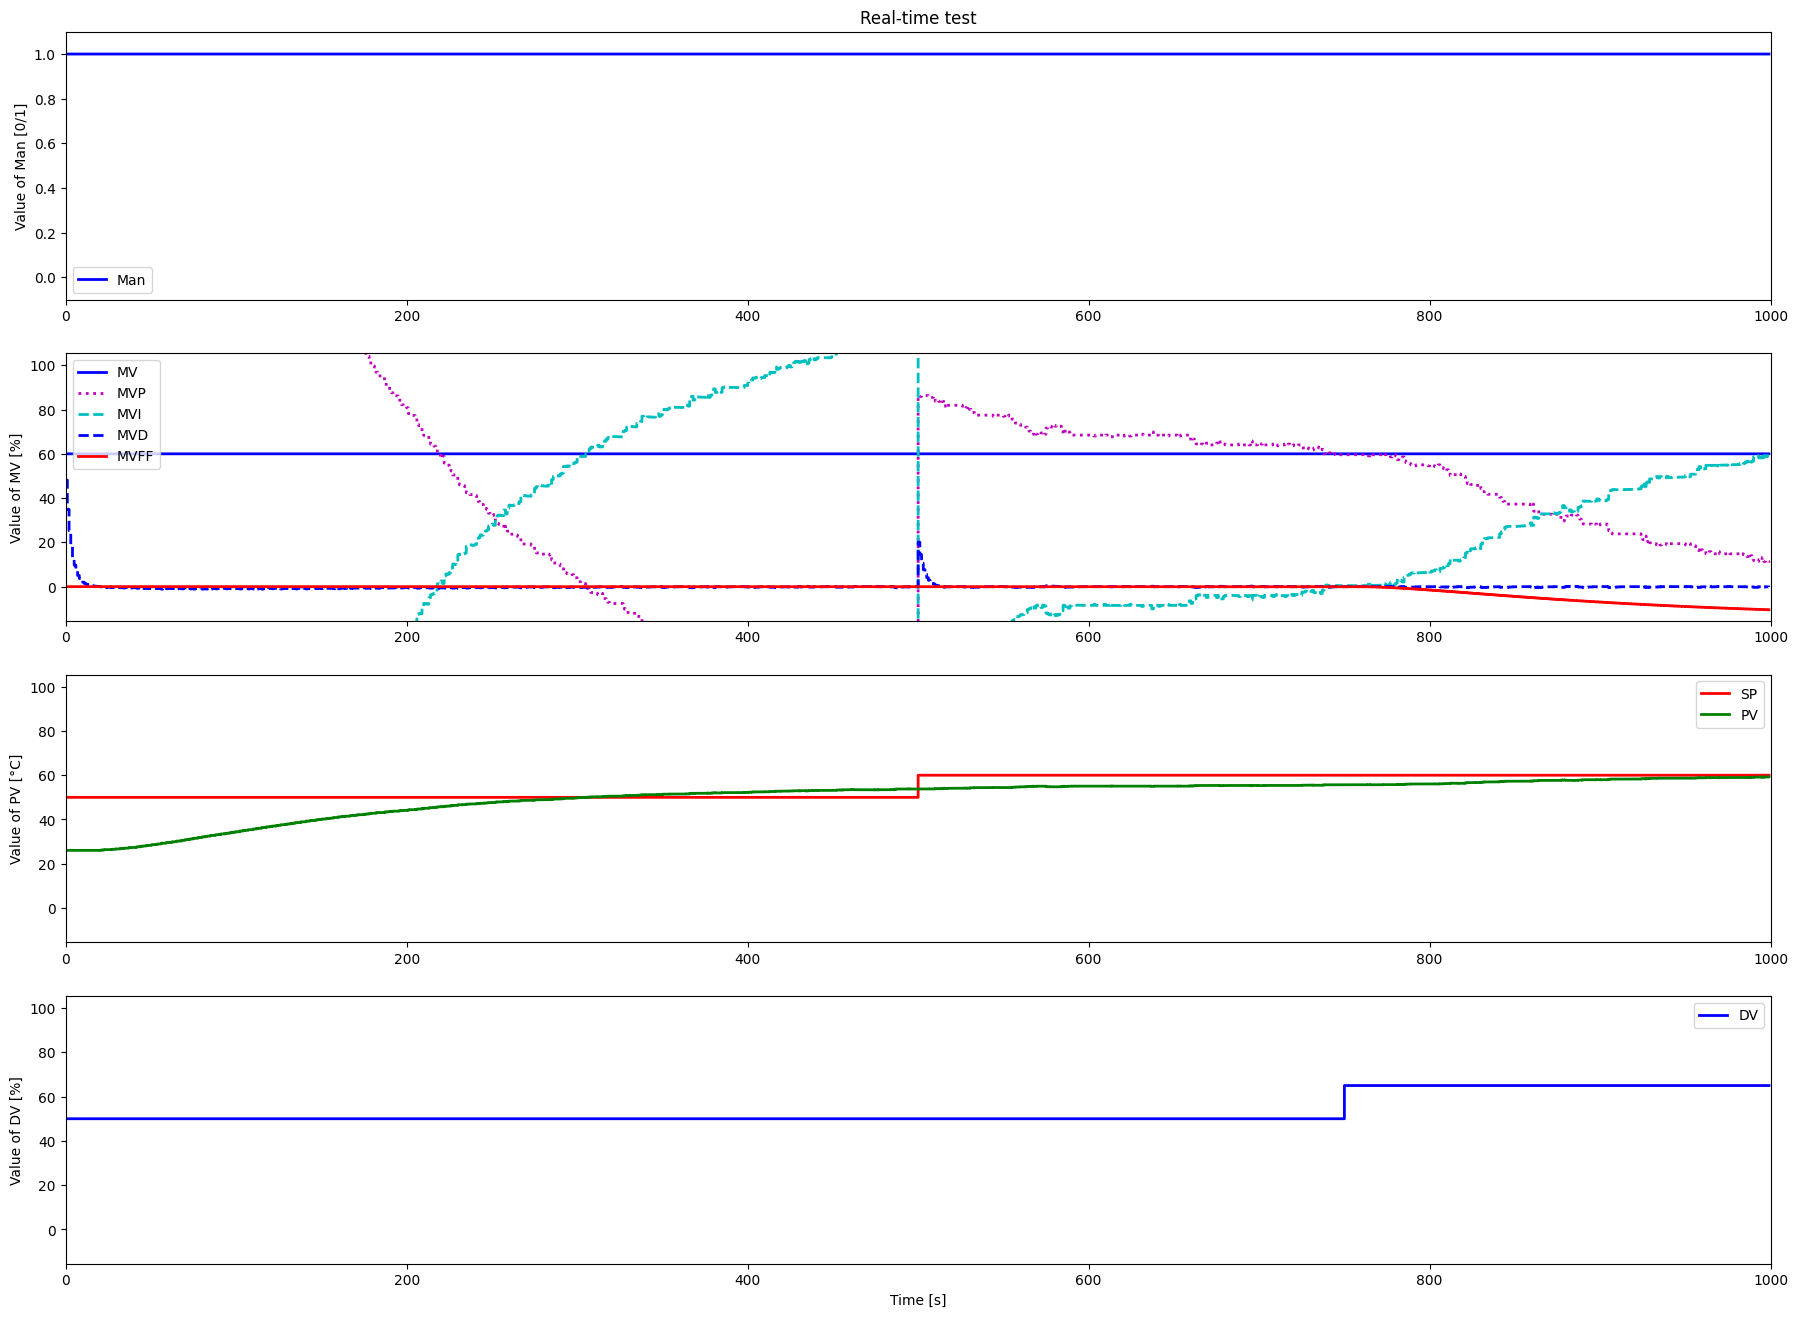

TCLab disconnected successfully.


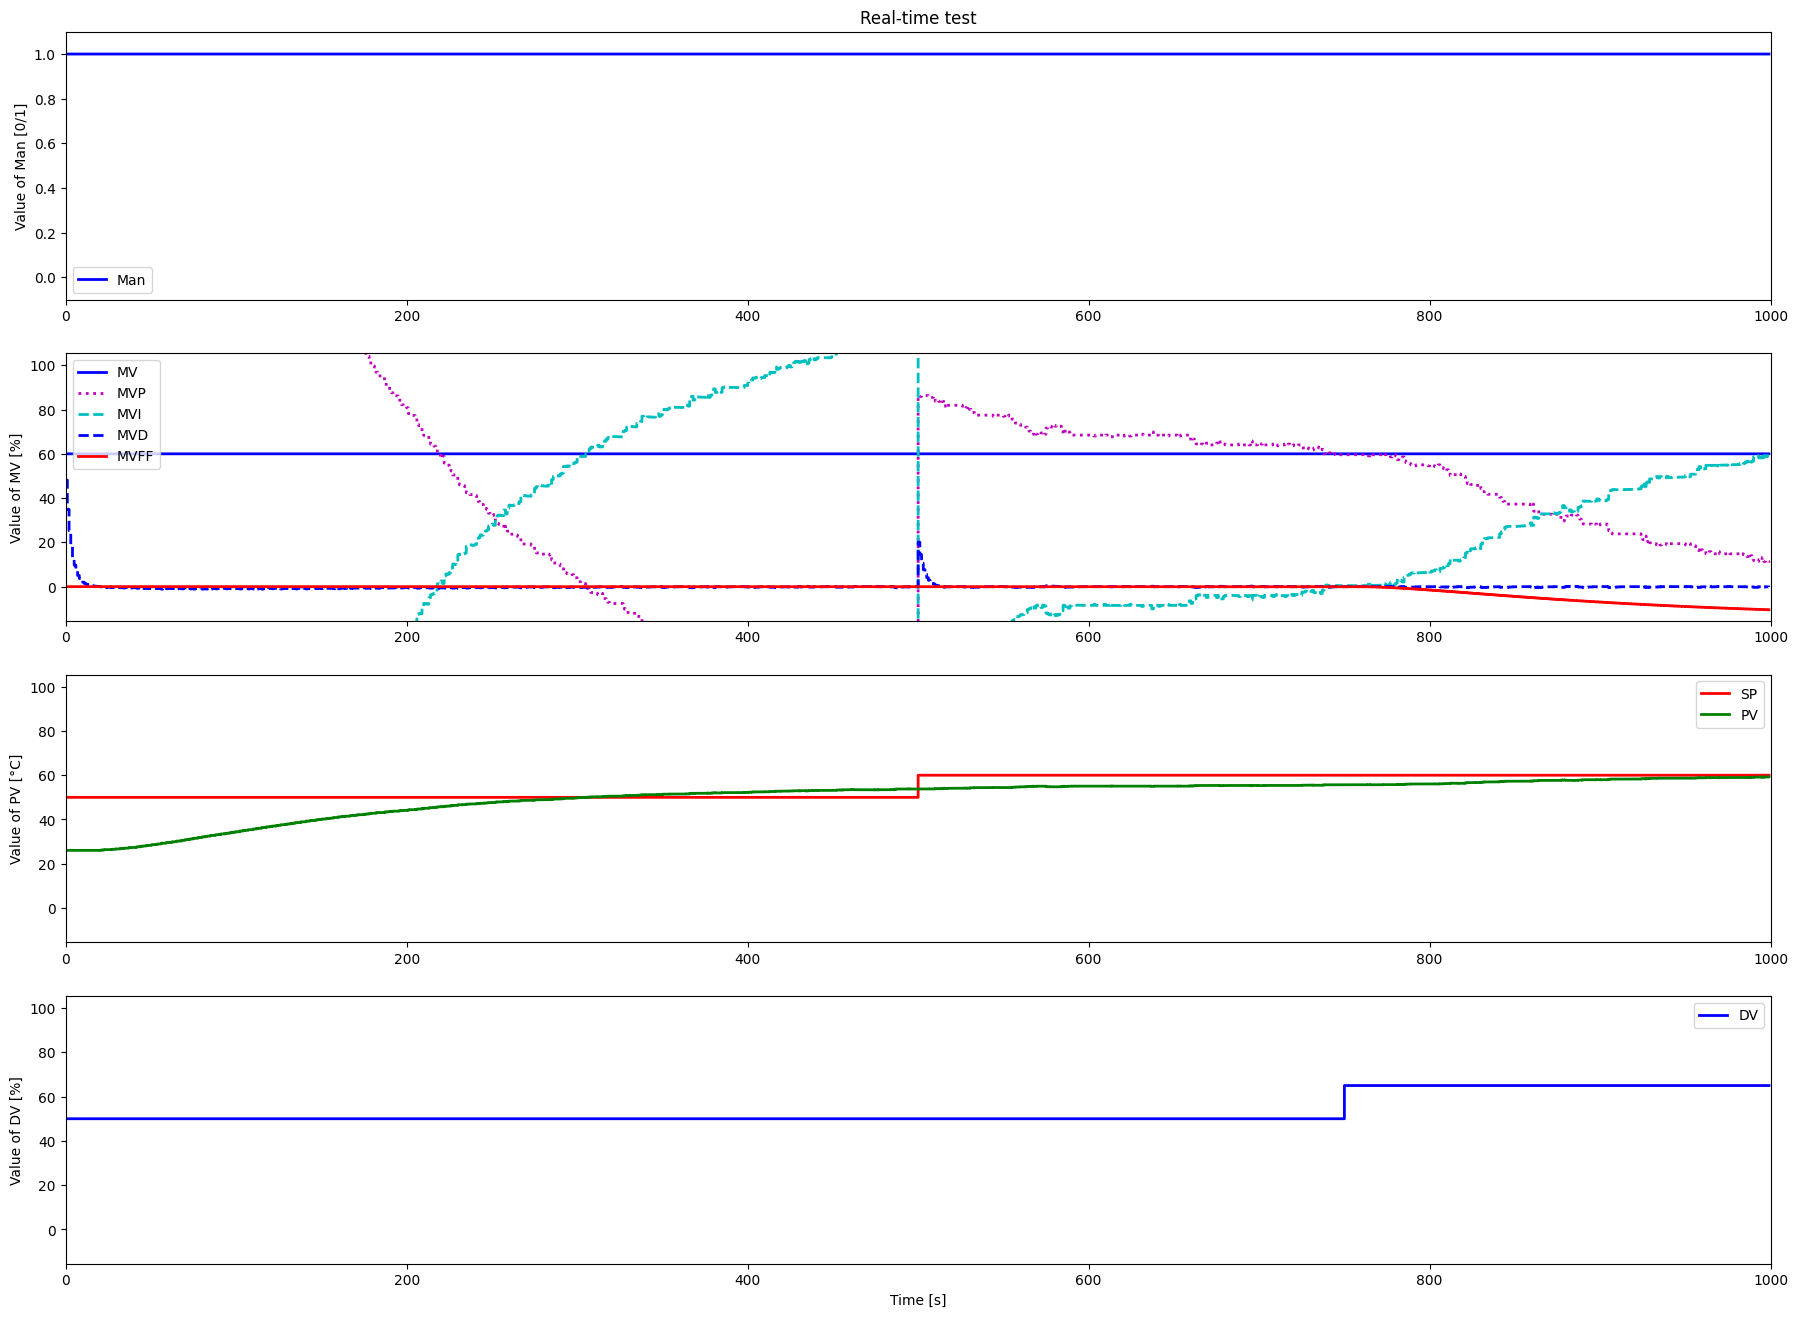

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(16)
fig.set_figwidth(22)

lman, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Man',where='post')
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel('Value of Man [0/1]')
ax1.set_title('Real-time test')
ax1.legend(loc='best')

lmv, = ax2.step([0,1],[-10,100],'b-',linewidth=2,label='MV',where='post')
lmvp, = ax2.step([0,1],[-10,100],'m:',linewidth=2,label='MVP',where='post')
lmvi, = ax2.step([0,1],[-10,100],'c--',linewidth=2,label='MVI',where='post')
lmvd, = ax2.step([0,1],[-10,100],'b--',linewidth=2,label='MVD',where='post')
lmvff, = ax2.step([0,1],[-10,100],'r-',linewidth=2,label='MVFF',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

lsp, = ax3.step([0,1],[-10,100],'r-',linewidth=2,label='SP',where='post')
lpv, = ax3.step([0,1],[-10,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('Value of PV [°C]')
ax3.legend(loc='best')

ldv, = ax4.step([0,1],[-10,100],'b-',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best') 

lab = tclab.TCLab()

Exp = True

t = []
SP = []
MV = []
MVP = []
MVI = []
MVD = []
PV = []
DV = []
MVFF = []
E = []
Man = []
MVMan = []
MVFF_Delay = []
MVFF_LL1 = []
i = 0

if mode == CLP_FF:
    UseFF = True
    ManPath = {0: True, Treach: False, NumRTsteps : False}
    MVManPath = {0:60, NumRTsteps:60}
elif mode == CLP_NOFF:
    UseFF = False
    ManPath = {0: True, Treach: False, NumRTsteps : False}
    MVManPath = {0:60, NumRTsteps:60}
elif mode == OLP_FF:
    UseFF = True
    ManPath = {0: True, NumRTsteps : True}
    MVManPath = {0:60, NumRTsteps:60}
    SPPath = {0: 50, NumRTsteps : 50}
    ManFF = True
elif mode == OLP_NOFF:
    UseFF = False
    ManPath = {0: True, NumRTsteps : True}
    SPPath = {0: 50, NumRTsteps : 50}
    MVManPath = {0:60, NumRTsteps:60}

# Path for variables
SPPath = {0: 50, 500: 60, NumRTsteps : 60}
DVPath = {0: 50, 750: 65, NumRTsteps : 0}

# Experiment is started
while Exp:
    t.append(i*Ts)

    if t[-1] == 0:
        last_time = time.time()

    PV.append(lab.T1)

    SelectPath_RT(DVPath, t, DV)
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)

    Delay_RT(DV-DV0*np.ones_like(DV),thetaFF,Ts,MVFF_Delay,0)

    LL_RT(MVFF_Delay,K_FF,TLEAD_LL1,TLAG_LL1,Ts,MVFF_LL1,0)
    if UseFF:
        LL_RT(MVFF_LL1, 1, TLEAD_LL2, TLAG_LL2, Ts, MVFF, 0)
    else:
        LL_RT(MVFF_LL1, 0, TLEAD_LL2, TLAG_LL2, Ts, MVFF, 0)

    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF)

    lab.Q1(MV[-1])
    lab.Q2(DV[-1])
    
    # Wait for sampling period Ts
    now = time.time()
    delta = now - last_time
    
    time.sleep(np.max([0, Ts - delta]))
    last_time = time.time()
    
    lman.set_data(t,Man)
    lmv.set_data(t,MV)
    lmvp.set_data(t,MVP)
    lmvi.set_data(t,MVI)
    lmvd.set_data(t,MVD)
    lmvff.set_data(t,MVFF)
    lsp.set_data(t,SP)
    lpv.set_data(t,PV)
    ldv.set_data(t,DV)
    
    clear_output(wait=True)    
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    
    if i > 1:
        pass
        #ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
        #ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
        #ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)
    
    display(fig)     
    
    i = i + 1
    
    if i == NumRTsteps:
        Exp = False
        lab.close()


# Save data in text file
# ----------------------
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
# Conversion to array
t = np.array(t) 
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
SP = np.array(SP)
PV = np.array(PV)
DV = np.array(DV)
Man = np.array(Man)
MVMan = np.array(MVMan)

my_data = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,SP.T,PV.T,DV.T,Man.T,MVMan.T,))
my_data = my_data.T
nameFile = 'Data/TCLab_PID_OLP_FF' + date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,SP,PV,DV,Man,MVMan,',comments='')


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'TCLab_PID_OLP_FF' + date_time
plt.savefig('Plots\\' + titleName + '.png',transparent=True)
plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)
